In [2]:
# # import the modules 
import praw 
from datetime import datetime
from textblob import TextBlob 
import networkx as nx, numpy as np, pandas as pd, matplotlib.pyplot as plt , re, time
%matplotlib inline

C:\Users\basav\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# # creating an authorized reddit instance 
reddit = praw.Reddit(
    client_id='IZh-17KfLVsGl6boaOga-A',
    client_secret='your client secret',
    password='your password',
    user_agent='ChardMany8896',
    username='ChardMany8896',
    )

In [4]:
def get_posts(subred_name, n):
    subreddit = reddit.subreddit(subred_name)
    posts_info = [] 
    
    for subm in subreddit.top(limit=n):
        
        subred_info = []
        subred_info.append(subm.id)  
        subred_info.append(str(subm.author)) 
        subred_info.append(subm.score)  
        subred_info.append(subm.upvote_ratio)
        subred_info.append(subm.num_comments)
        subred_info.append(subm.subreddit)
        posts_info.append(subred_info)
    
    sorted_info = sorted(posts_info, key=lambda x: x[1], reverse = True)
    posts_df = pd.DataFrame(sorted_info, columns = ['id','author', 'score','upvote_ratio' ,'num_comments', 'subreddit'])
    return posts_df
python_df = get_posts('Python', 100)
python_df.head(100)



,id,author,score,upvote_ratio,num_comments,subreddit
0,7mwgtw,winner_godson,4200,0.93,124,Python
1,abjuw4,tycooperaow,2598,0.95,175,Python
2,er9q4h,toastyCSboi,3869,0.98,116,Python
3,8fztrr,themonsterpus,2445,0.96,391,Python
4,g7q2ej,swallowedlava,2691,0.99,141,Python
...,...,...,...,...,...,...
95,f35yg0,Ani171202,4040,0.97,227,Python
96,cmdbuf,Alexanderdaawesome,4282,0.96,376,Python
97,otbvoj,AlSweigart,2492,0.98,533,Python
98,jui7zw,-sideshow-,3931,0.99,167,Python


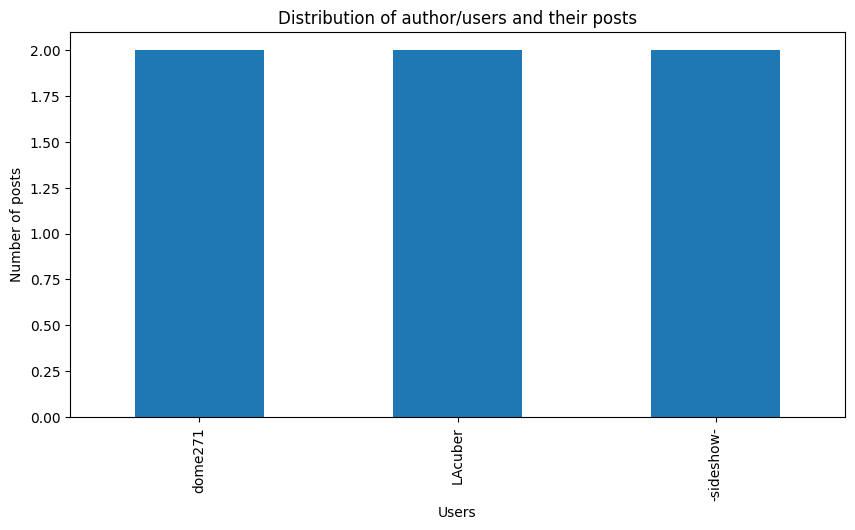

In [5]:
# Data Cleaning

freq_authors = python_df[python_df.duplicated(['author'], keep = False)] # users who have posted more than once
freq_authors = freq_authors[freq_authors.author != 'None'] #  Getting rid of deleted users
freq_authors.author.nunique() #There are 41 users out of 500 who have posted more than once

# The bar graph shows the distribution of users out of 500 who featured posts on r/python, more than once.

plt.figure(figsize=(10, 5))
author_counts = freq_authors['author'].value_counts()
if not author_counts.empty:
    ax = author_counts.plot(kind='bar', title='Distribution of author/users and their posts')
    ax.set_xlabel("Users")
    ax.set_ylabel("Number of posts")
else:
    print("No data to plot")


In [6]:
authors_lst = ["Python",'AskReddit', 'Programming', 'machinelearning', "gaming", "worldnews",
             "todayilearned", "Music", "movies", "science", "pics", "memes", "Jokes",
             "InternetIsBeautiful", "technology"]  

authors_df =  pd.DataFrame() 

for u in authors_lst: 
    c = get_posts(u, 10)
    authors_df = pd.concat([authors_df, c])

authors_df.head(11)

,id,author,score,upvote_ratio,num_comments,subreddit
0,irh8l0,paulkaefer,6502,0.96,249,Python
1,gftejm,jessjwilliamson,7866,0.96,266,Python
2,dmkx8a,janky_british_gamer,6613,0.97,468,Python
3,g53lxf,iEslam,12345,0.98,133,Python
4,7kpme8,backprop88,6722,0.94,325,Python
5,hqc7ol,atqm-,5694,0.99,212,Python
6,ghxqod,Nekose,5543,0.98,203,Python
7,hoolsm,Krukerfluk,9233,0.91,437,Python
8,gn9add,Itwist101,5720,0.98,121,Python
9,iehths,HotTeenBoy,5448,0.97,112,Python


In [7]:
# NETWORK ANALYSIS USING NetworkX
nx_df = authors_df[['author','subreddit',]]
nx_df.head()


,author,subreddit
0,paulkaefer,Python
1,jessjwilliamson,Python
2,janky_british_gamer,Python
3,iEslam,Python
4,backprop88,Python


In [8]:

# Graph with nodes('subreddits) and edges('authors/users')
g = nx.from_pandas_edgelist(nx_df, source='author', target='subreddit')
print(g)

Graph with 156 nodes and 144 edges


In [9]:
# Top 10 Subreddits with maximum Degree Centrality
centrality = nx.degree_centrality(g)
[(x,centrality[x]) for x in sorted(centrality, key = centrality.get, reverse = True)[:10]]

[(Subreddit(display_name='Python'), 0.06451612903225806),
 (Subreddit(display_name='AskReddit'), 0.06451612903225806),
 (Subreddit(display_name='programming'), 0.06451612903225806),
 (Subreddit(display_name='gaming'), 0.06451612903225806),
 (Subreddit(display_name='worldnews'), 0.06451612903225806),
 (Subreddit(display_name='todayilearned'), 0.06451612903225806),
 (Subreddit(display_name='pics'), 0.06451612903225806),
 (Subreddit(display_name='memes'), 0.06451612903225806),
 (Subreddit(display_name='Jokes'), 0.06451612903225806),
 (Subreddit(display_name='InternetIsBeautiful'), 0.06451612903225806)]

In [10]:
# Top 10 Subreddits with maximum Closeness Centrality
centrality = nx.closeness_centrality(g)
[(x,centrality[x]) for x in sorted(centrality, key = centrality.get, reverse = True)[:10]]

[(Subreddit(display_name='pics'), 0.08347394540942929),
 ('None', 0.07432611577551922),
 ('ReallyRickAstley', 0.07234408602150538),
 ('bemmu', 0.06791171477079795),
 (Subreddit(display_name='programming'), 0.0661703887510339),
 (Subreddit(display_name='InternetIsBeautiful'), 0.0661703887510339),
 (Subreddit(display_name='technology'), 0.06537116206762535),
 (Subreddit(display_name='Python'), 0.06451612903225806),
 (Subreddit(display_name='AskReddit'), 0.06451612903225806),
 (Subreddit(display_name='gaming'), 0.06451612903225806)]

In [11]:
# Betweenness Centrality
centrality = nx.betweenness_centrality(g)
[(x,centrality[x]) for x in sorted(centrality, key = centrality.get, reverse = True)[:10]]

[(Subreddit(display_name='pics'), 0.025638877251780476),
 (Subreddit(display_name='technology'), 0.018098031001256808),
 (Subreddit(display_name='Music'), 0.016422287390029325),
 ('None', 0.015919564306661083),
 ('ReallyRickAstley', 0.01508169250104734),
 (Subreddit(display_name='programming'), 0.011311269375785506),
 (Subreddit(display_name='InternetIsBeautiful'), 0.011311269375785506),
 ('bemmu', 0.008378718056137411),
 (Subreddit(display_name='Python'), 0.003770423125261835),
 (Subreddit(display_name='AskReddit'), 0.003770423125261835)]

In [12]:
# # Eigenvector Centrality
# centrality = nx.eigenvector_centrality(g)
# [(x,centrality[x]) for x in sorted(centrality, key = centrality.get, reverse = True)[:10]]

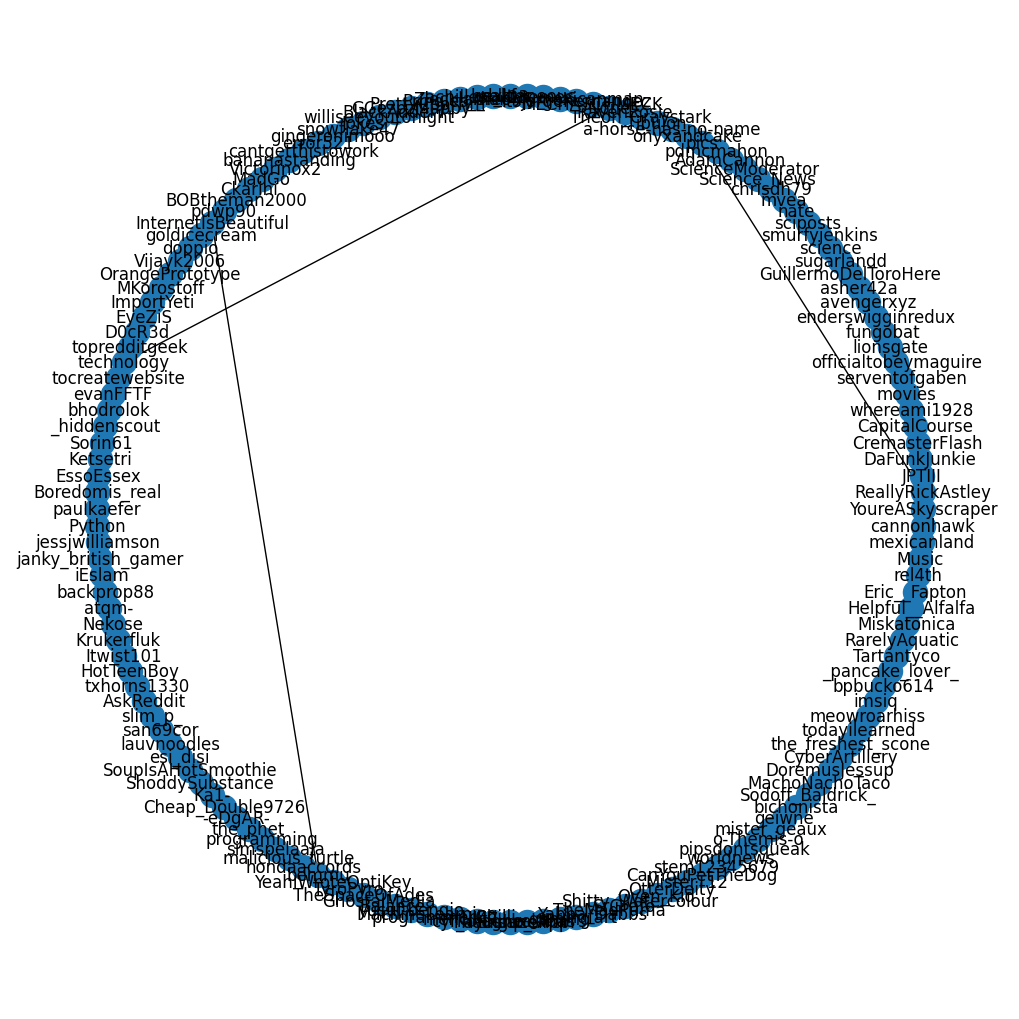

In [13]:
# GRAPH VISUALIZATIONS
from matplotlib.pyplot import figure
figure(figsize=(10, 10))
nx.draw_shell(g, with_labels=True)

In [14]:
leaderboard = {}
for x in g.nodes:
 leaderboard[x] = len(g[x])
s = pd.Series(leaderboard, name='connections')
df_conn = s.to_frame().sort_values('connections', ascending=False)
df_conn.head()

,connections
todayilearned,10
technology,10
pics,10
programming,10
memes,10


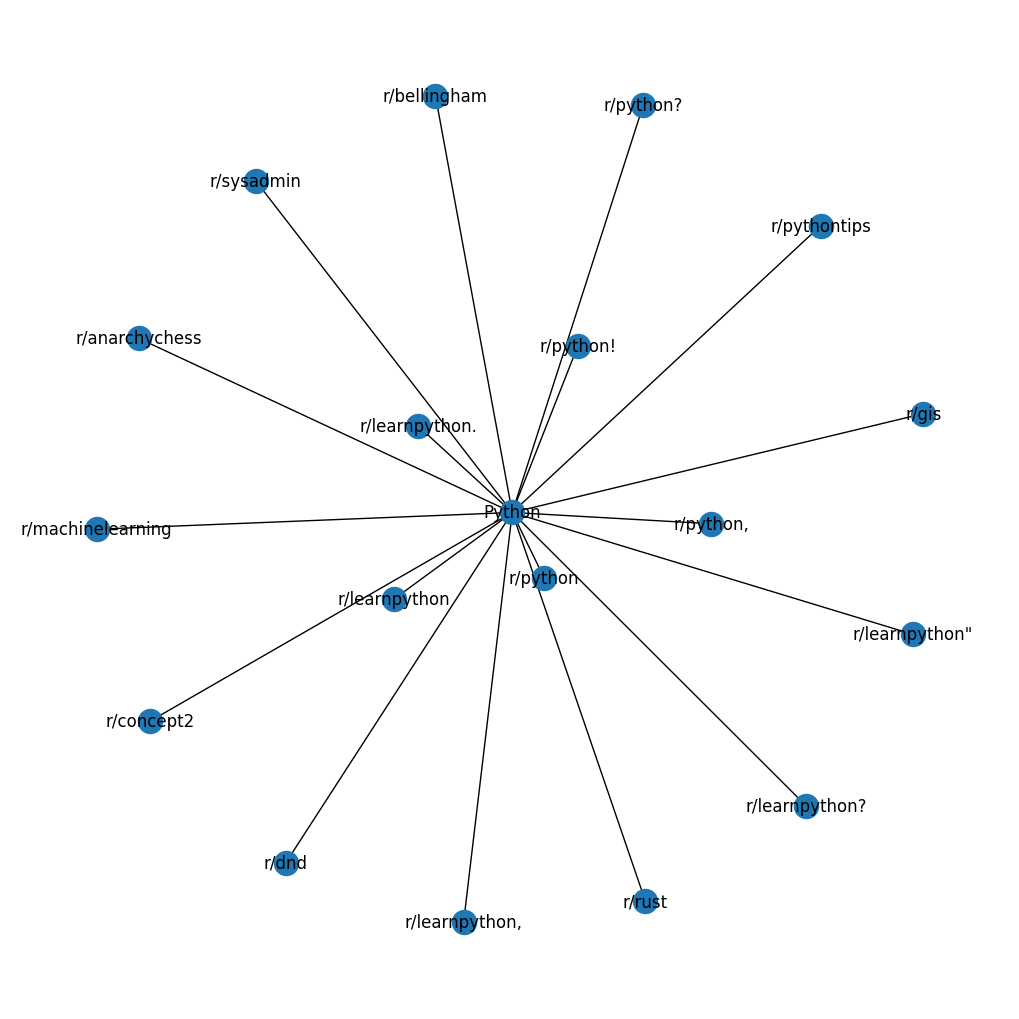

In [15]:


def get_related_subreddits(subreddit_name, n):
    subreddit = reddit.subreddit(subreddit_name)
    related_subreddits = {}

    # Get n hot posts from the subreddit
    for submission in subreddit.hot(limit=n):
        # Get a list of subreddits mentioned in the comments
        submission.comments.replace_more(limit=None)
        for comment in submission.comments.list():
            for word in comment.body.split():
                if word.lower().startswith('r/'):
                    related_subreddits[word.lower()] = related_subreddits.get(word.lower(), 0) + 1

    return related_subreddits

# Get related subreddits
related_subreddits = get_related_subreddits('Python', 500)

# Create a graph
G = nx.Graph()

# Add edges to the graph
for subreddit, weight in related_subreddits.items():
    G.add_edge('Python', subreddit, weight=weight)

# Draw the graph
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, seed=42)  # positions for all nodes
nx.draw(G, pos, with_labels=True)
plt.show()


In [16]:

# Assuming nx_df is a DataFrame with 'author' and 'subreddit' columns
g = nx.from_pandas_edgelist(nx_df, source='author', target='subreddit')

# Create a layout for nodes 
layout = nx.spring_layout(g, iterations=50, scale=2)

subs = list(nx_df['subreddit'].unique())


subs = [sub for sub in subs if sub in g.nodes]
authors_lst = [author for author in authors_lst if author in g.nodes]


nx.draw_networkx_nodes(g, 
                       layout, 
                       nodelist=subs, 
                       node_size=sub_size, 
                       node_color='powderblue')

# Assuming authors_lst is a list of authors
nx.draw_networkx_nodes(g, layout, nodelist=authors_lst, node_color='green', node_size=100)

# Draw highly connected influencers 
popular_people = [person for person in authors_lst if g.degree(person) > 1]
nx.draw_networkx_nodes(g, layout, nodelist=popular_people, node_color='orange', node_size=100)

nx.draw_networkx_edges(g, layout, width=1, edge_color="lightgreen")

node_labels = dict(zip(subs, subs)) #labels for subs
nx.draw_networkx_labels(g, layout, labels=node_labels)

plt.axis('off')
plt.title("Network Graph of Related Subreddits")
plt.show()


NameError: name 'sub_size' is not defined